# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [4]:
%config IPCompleter.greedy=True
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
# Imports here
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import torch
import json

from torchvision import datasets, transforms, models
from workspace_utils import active_session
from collections import OrderedDict
from torch import optim
from torch import nn
from PIL import Image

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [6]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [7]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(DEVICE)

# Hyper-parameters
BATCH_SIZE = 32  # how many images to train per step

INPUT_SIZE = 25088  # default number of classifier inputs
OUTPUT_SIZE = 102  # Number of possible flower categories
HIDDEN_LAYERS = [4096, 2048]  # Sizes of the hidden layer(s)
DROPOUT_PROBABILITY = 0.5  # 50%

LEARN_RATE = 1e-4

EPOCHS = 5  # number of epochs to train the data
PRINT_EVERY = 25  # prints every 'x' steps

In [8]:
# DONE: Define your transforms for the training, validation, and testing sets


train_transforms = transforms.Compose([  # Transforms for the data we'll use to train our classifier
    transforms.RandomRotation(30),  # Randomly rotates the image between -30 and 30 degrees
    transforms.RandomResizedCrop(224),  # Resize and random crop that outputs a 224x224 pixels image
    transforms.RandomHorizontalFlip(),  # Randomly flips the image on the horizontal axis
    transforms.ToTensor(),  # Turn image data into a tensor of pixels (224x224) to be processed by PyTorch
    # Normalize the color channels so that each pixel is normally distributed around 0 from -1 to 1. 
    # These values come from the pre-trained model
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([  # Transforms for the data we'll use to validate the model
    transforms.Resize(256),  # Resize the image so that the smaller edge is of the desired size
    transforms.CenterCrop(224),  # Crop a centered square of 224 pixels
    transforms.ToTensor(),  # Turn image data into a tensor of pixels (224x224) to be processed by PyTorch
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])  # Normalize the color channels

test_transforms = transforms.Compose([  # Transforms for the data we'll use to test the model
    transforms.Resize(256),  # Resize the image so that the smaller edge is of the desired size
    transforms.CenterCrop(224),  # Crop a centered square of 224 pixels
    transforms.ToTensor(),  # Turn image data into a tensor of pixels (224x224) to be processed by PyTorch
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])  # Normalize the color channels

# DONE: Load the datasets with ImageFolder

# Data to use in the training process
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)

# Data to use tto validate the training
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transforms)

# Data to use to test the model
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# DONE: Using the image datasets and the trainforms, define the dataloaders

# Train data loader. The order of every batch is shuffled
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Validation data loader. The order of every batch is shuffled
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Test data loader. No need to shuffle
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [9]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [10]:
# Load a pre-trained network with Torchvision. We'll use VGG 16


model = models.vgg16(pretrained=True)

INPUT_SIZE = model.classifier[0].in_features  # Read the model feature output size

# Freeze the parameters so that we don't train this part of the network
for param in model.parameters():
    param.requires_grad = False

In [11]:
# DONE: Build and train your network


class ClassifierModel(nn.Module):  # Define the classifier network
    
    def __init__(self, input_size, output_size, hidden_layers, drop_p = 0.5):
        """Initialize the network
        Arguments:
            input_size -- number of neurons of the input layer
            output_size -- number of outputs
            hidden_layers -- number of neurons of each hidden layer
            drop_p -- probability for a neuron to be deactivated
        """
        super(ClassifierModel, self).__init__()
        
        # Create input-output sizes from the hidden_layers values
        hidden_sizes = zip(hidden_layers[:-1], hidden_layers[1:])  # trick from "Inference & Validation" video
        
        # Input layer takes 'input_size' as input and outputs 'first hidden layer's size'
        self.layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Hidden layers. h_1 represents the input to the layer and h_2 its output
        self.layers.extend([nn.Linear(h_1, h_2) for h_1, h_2 in hidden_sizes])
        
        # Last layer takes as input the 'last hidden layer's' output and outputs 'output_size'
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        # Implement dropout
        self.dropout = nn.Dropout(p=drop_p)
    
    
    def forward(self, input):
        """Feeds the input forward through the network

        Arguments:
            input -- The network input batch data
        
        Returns:
            The log of the probability distribution of the categories for each input
        """
        output = input
        # feed through the hidden layers
        for linear_layer in self.layers:
            output = linear_layer(output)  # Linear calculation
            output = F.relu(output)  # Non-linearity of the layer
            output = self.dropout(output)  # Dropout
            
        output = self.output(output)  # last layer
        # returns the probabilities distributions of the dimension 1 (dim=0 is the batch size)
        return F.log_softmax(output, dim=1)

# Replace the pretrained classifier with our classifier model
model.classifier = ClassifierModel(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_LAYERS, DROPOUT_PROBABILITY)

In [12]:
def validate_model(model, valid_loader, criterion = None):
    """Validate the accuracy of the model with validation data
    during training or test data after

    Arguments:
        model -- The model to validate
        valid_loader -- Validation/Test data loader
        criterion -- Loss function used by the model

    Returns:
        The loss and accuracy of the model W.R.T. the validation/test data
    """
    valid_loss = 0  # Running loss of the validation batch
    accuracy = 0  # Accuracy of the classifier
    
    for inputs, labels in valid_loader:  # for each batch of data / label
        
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        output = model.forward(inputs)  # feed forward
        
        # We only calculate the loss for validation data while training
        if criterion is not None:
            loss = criterion(output, labels)  # calculate the loss
            valid_loss += loss.item()
        
        probabilities = torch.exp(output)  # Exponential because the output is the log of prob. distribution
        
        # Compare the class label with the most probable classification class from our classifier
        # dim=1 because dim=0 is the batch size
        # [1] because max returns the max probability value on [0] and the index (our classes) on [1]
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()  # the average of right classifications
    
    return valid_loss, accuracy

In [13]:
criterion = nn.NLLLoss() # Our loss function will be 'negative log likelihood'
# we only want to optimize our classifier parameters
optimizer = optim.Adam(model.classifier.parameters(), lr=LEARN_RATE)

# makes PyTorch use 'device' to compute
model.to(DEVICE)
criterion.to(DEVICE)

NLLLoss()

In [10]:
# Train the classifier network


#with active_session():
step = 0
for epoch in range(EPOCHS):  # for each epoch
    running_loss = 0
    print("Epoch: {}/{}".format(epoch+1, EPOCHS))
    print("==========")
    for inputs, labels in train_loader:  # for each batch of data / label
        step += 1
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()  # resets gradients to zero

        output = model.forward(inputs)  # feed forward
        loss = criterion(output, labels)  # calculate the loss
        loss.backward()  # back propagate the loss
        optimizer.step()  # do gradient descent

        running_loss += loss.item()
        
        if step % PRINT_EVERY == 0:

            model.eval()  # Turn off dropout to make the validation pass

            with torch.no_grad():  # Turn off gradients for the validation pass
                valid_loss, accuracy = validate_model(model, valid_loader, criterion)

            print("Training Loss: {:.3f}.. ".format(running_loss/PRINT_EVERY),
                  "Validation Loss: {:.3f}.. ".format(valid_loss/len(valid_loader)),
                  "Validation Accuracy: {:.3f}".format(accuracy/len(valid_loader)))

            running_loss = 0

            model.train()  # enable dropout back

    model.eval()  # Turn off dropout to make the validation pass

    with torch.no_grad():  # Turn off gradients for the validation pass
        valid_loss, accuracy = validate_model(model, valid_loader, criterion)

    print("\nEpoch: {}/{}.. ".format(epoch+1, EPOCHS),
          "Validation Loss: {:.3f}.. ".format(valid_loss/len(valid_loader)),
          "Validation Accuracy: {:.3f}\n".format(accuracy/len(valid_loader)))

    model.train()  # enable dropout back

Epoch: 1/5
Training Loss: 4.546..  Validation Loss: 4.257..  Validation Accuracy: 0.104
Training Loss: 4.315..  Validation Loss: 3.852..  Validation Accuracy: 0.198
Training Loss: 3.943..  Validation Loss: 3.302..  Validation Accuracy: 0.279
Training Loss: 3.535..  Validation Loss: 2.802..  Validation Accuracy: 0.321
Training Loss: 3.171..  Validation Loss: 2.405..  Validation Accuracy: 0.458
Training Loss: 2.812..  Validation Loss: 1.994..  Validation Accuracy: 0.531
Training Loss: 2.542..  Validation Loss: 1.761..  Validation Accuracy: 0.553
Training Loss: 2.370..  Validation Loss: 1.559..  Validation Accuracy: 0.614

Epoch: 1/5..  Validation Loss: 1.502..  Validation Accuracy: 0.634

Epoch: 2/5
Training Loss: 1.573..  Validation Loss: 1.395..  Validation Accuracy: 0.649
Training Loss: 1.977..  Validation Loss: 1.260..  Validation Accuracy: 0.688
Training Loss: 1.873..  Validation Loss: 1.152..  Validation Accuracy: 0.700
Training Loss: 1.766..  Validation Loss: 0.980..  Validation A

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [16]:
# DONE: Do validation on the test set

# Test model accuracy with the Test Data


model.eval()  # Turn off dropout to validate the model with test data

with torch.no_grad():  # Turn off gradients to validate the model with test data
    _, accuracy = validate_model(model, test_loader)

print("Testing Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Testing Accuracy: 0.886


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [13]:
# Done: Save the checkpoint 


def save_model():
    """Saves the model state after training is complete"""
    
    model.class_to_idx = train_dataset.class_to_idx

    trained_checkpoint = {
        'input_size': INPUT_SIZE,
        'output_size': OUTPUT_SIZE,
        'hidden_layers': HIDDEN_LAYERS,
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARN_RATE,
        'model':  models.vgg16(pretrained=True),
        'classifier': model.classifier,
        'class_to_idx': model.class_to_idx,
        'state': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }

    torch.save(trained_checkpoint, 'vgg_checkpoint.pth')
    print("Model was successfully saved!")
    
save_model()

C:\Users\Massena\Anaconda3\envs\pytorch\lib\site-packages\torch\serialization.py:193: UserWarning: Couldn't retrieve source code for container of type ClassifierModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Model was successfully saved!


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [15]:
# DONE: Write a function that loads a checkpoint and rebuilds the model


def load_model():
    """Load a previously saved model state

    Returns:
        The recreated model with all the information that was saved
    """
    global LEARN_RATE, optimizer
    
    state = torch.load('vgg_checkpoint.pth')
    
    model = state['model']  # Load pretrained model
    
    # Replace the classifier with saved one
    model.classifier = state['classifier']
    
    model.load_state_dict(state['state'])
    model.class_to_idx = state['class_to_idx']
    
    optimizer = state['optimizer']
    LEARN_RATE = state['learning_rate']
    EPOCHS = state['epochs']
    
    model.to(DEVICE)
    
    for param in model.parameters():
        param.requires_grad = False
    
    print("Model was successfully loaded!")
    
    return model

model = load_model()

Model was successfully loaded!


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [17]:
# DONE: Process a PIL image for use in a PyTorch model


def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    target_size = 256
    crop_size = 224
    
    width, height = image.size
    
    # Check which side is the shortest to resize it to target_size and scale the other one
    if(width > height):  
        width = int(width * target_size / height)
        height = int(target_size)  
    else:
        height = int(height * target_size / width)
        width = int(target_size)
    
    image = image.resize((width, height))
    
    # Crop the center of the image
    left = (width - crop_size) / 2
    top = (height - crop_size) / 2
    right = left + crop_size
    bottom = top + crop_size
    
    image = image.crop((left, top, right, bottom))
    
    # Get a numpy array from the image
    np_image = np.array(image) / 255
    
    # Normalizes the image array
    image_mean = np.array([0.485, 0.456, 0.406])
    image_std = np.array([0.229, 0.224, 0.225])
    normalized_image = (np_image - image_mean) / image_std
    
    # Change the channels order
    normalized_image = normalized_image.transpose((2, 0, 1))
    
    return normalized_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [18]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [31]:
# DONE: Implement the code to predict the class from an image file


def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.'''
    
    image = Image.open(image_path)  # Load image from filesystem
    np_image = process_image(image)  # Preprocess it into a numpy array
    tensor_image = torch.from_numpy(np_image)  # Turn it into a tensor
    
    # Model expects 4 dimensions (first is batch size)
    tensor_image = tensor_image.unsqueeze(0)
    
    output = model.forward(tensor_image.float().to(DEVICE))  # Feed forward through the model
    probabilities = torch.exp(output).cpu()  # Get the exp of the log_softmax probabilities
    
    probabilities = probabilities.data.topk(topk)  # Get the top K probabilities
    
    # Revert the mapping from index to classes
    idx_to_class = {model.class_to_idx[idx]: idx for idx in model.class_to_idx}
    
    # Get the top classes that were mapped for this prediction
    mapped_classes = [idx_to_class[label] for label in probabilities[1].numpy()[0]]
    
    return probabilities[0].numpy()[0], mapped_classes

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

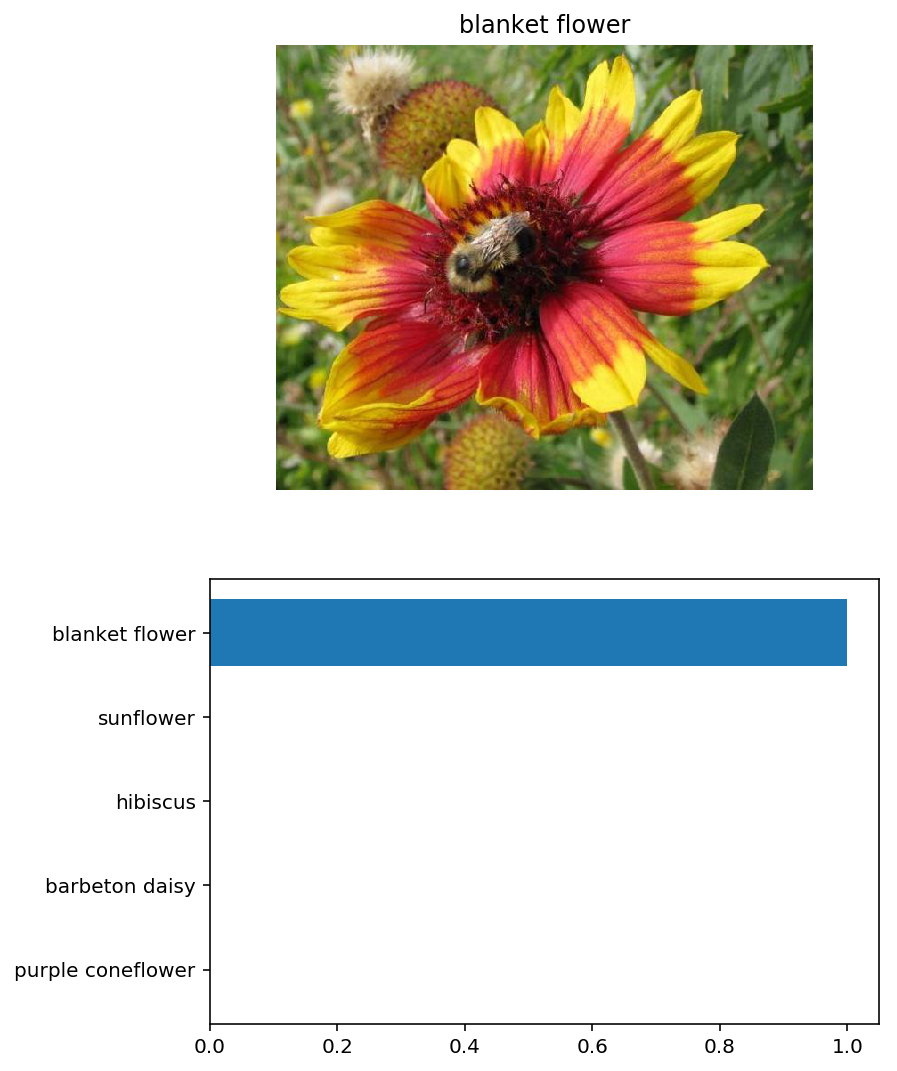

In [32]:
# DONE: Display an image along with the top 5 classes


# test_image_path = test_dir + '/2/image_05109.jpg'
# test_image_path = test_dir + '/12/image_03994.jpg'
test_image_path = test_dir + '/100/image_07896.jpg'

probabilities, classes = predict(test_image_path, model)
_, (ax1, ax2) = plt.subplots(figsize=(6, 9), ncols=1, nrows=2)

# Display image
ax1.axis('off')
ax1.set_title(cat_to_name[classes[0]])
ax1.imshow(Image.open(test_image_path));

# Display Probabilities chart
labels = [cat_to_name[idx] for idx in classes]  # Loads the mapped labels names

y_ticks = np.arange(len(labels))  # Number of y ticks is the number of top classes
ax2.set_yticks(y_ticks)
ax2.set_yticklabels(labels)
ax2.invert_yaxis()  # Invert the order
ax2.barh(y_ticks, probabilities);  # horizontal bar chart